# Protein Close Residues Lifting (Graph to Hypergraph)

***
This notebook imports UniProt protein data and creates a lifting from the graph of the protein to an hypergraph.
Then, a neural network is run using the loaded data.

The UniProt dataset is a custom dataset that is created by fetching data from the UniProt API.
The dataset is created by fetching a list of proteins based on a query and then fetching the structure of each protein using the AlphaFold API. The dataset is then created by creating a graph for each protein where the nodes are the residues and edges are the connections between residues. These connections are usually done by the closeness of the residues. In this example, we connect the residues in two ways, representing the data into a graph:
- **Sequentialwise**: Connecting residues that appear in a sequential order (one after another). This approach is based on the presence of peptide bonds, which link the amino acids in a protein chain in a specific sequence.
- **Closewise**: Connecting residues that are close to each other (under than a *threshold*) and the direction between CarbonAlpha (CA) and CarbonBeta (CB) atoms of each residue are less than 90 degrees between different residues. This approach ensures that residues are connected when they are in close proximity and have a similar orientation, indicating that their spatial arrangement and orientation are biologically appropriate (the residues are appropriated with a similar orientation).

The target variable is the mass of the protein.

This representation can be improved by lifting it to an hypergraph. 
As done in [Jiang et al. (2021)](https://www.nature.com/articles/s41524-021-00493-w), we will create an hypergraph by grouping the connected residues that are close to each other (less than a parameter).

Under this submission the following steps are done:

- [Loading the dataset](#loading-the-dataset) loads the config files for loading UniProt dataset and a creating a graph connecting the atoms as mentioned above.
- [Loading and applying the lifting](#loading-and-applying-the-lifting) done by creating a close residue lifting, computing the distance between the connected residues and grouping them when are under a threshold. These residues will be connected by an hyperedge inside an hypergraph.
- [Create and run a simplicial nn model](#create-and-run-a-simplicial-nn-model) simply runs a forward pass of the model to check that everything is working as expected.

***
***

Note that for simplicity the notebook is setup to use a simple graph. However, there is a set of available datasets that you can play with.

To switch to one of the available datasets, simply change the *dataset_name* variable in [Dataset config](#dataset-config) to one of the following names:

* cocitation_cora
* cocitation_citeseer
* cocitation_pubmed
* MUTAG
* NCI1
* NCI109
* PROTEINS_TU
* AQSOL
* ZINC
* UniProt

With this implementation, also **UniProt** is available.
***

### Imports and utilities

In [61]:
# With this cell any imported module is reloaded before each cell execution
%load_ext autoreload
%autoreload 2
from modules.data.load.loaders import GraphLoader
from modules.data.preprocess.preprocessor import PreProcessor
from modules.utils.utils import (
    describe_data,
    load_dataset_config,
    load_model_config,
    load_transform_config,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading the dataset

Here we just need to specify the name of the available dataset that we want to load, in this case, UniProt dataset. First, the dataset config is read from the corresponding yaml file (located at `/configs/datasets/` directory), and then the data is loaded via the implemented `Loaders`.

In the dataset, different parameters are specified to load the data from the API, such as the number of samples to load (*limit*), the number of residues per protein (query: length),...

Moreover, there is the *threshold* parameter that is used to group residues that are close to each other. This parameter is used to create the initial graph.


In [62]:
dataset_name = "UniProt"
dataset_config = load_dataset_config(dataset_name)
loader = GraphLoader(dataset_config)


Dataset configuration for UniProt:

{'data_domain': 'graph',
 'data_type': 'UniProt',
 'data_name': 'UniProt',
 'data_dir': 'datasets/graph/UniProt',
 'query': 'length:[95 TO 155]',
 'format': 'tsv',
 'fields': 'accession,length',
 'size': 100,
 'threshold': 6.0,
 'num_features': 20,
 'num_classes': 1,
 'task': 'regression',
 'loss_type': 'mse',
 'monitor_metric': 'mae',
 'task_level': 'graph'}


We can then access to the data through the `load()`method. 

In [75]:
dataset = loader.load()
describe_data(dataset)

PDB file for P02776 already exists.
PDB file for O14960 already exists.
PDB file for A8MQ03 already exists.
PDB file for O43914 already exists.
PDB file for Q16143 already exists.
PDB file for P61956 already exists.
PDB file for P61088 already exists.
PDB file for A6NNB3 already exists.
PDB file for P26885 already exists.
PDB file for P0DPB6 already exists.
PDB file for A2RU14 already exists.
PDB file for P55854 already exists.
PDB file for P80098 already exists.
PDB file for O15116 already exists.
PDB file for P0DI82 already exists.
PDB file for A6NFY7 already exists.
PDB file for P49901 already exists.
PDB file for P01308 already exists.
PDB file for Q16718 already exists.
PDB file for P0C5Z0 already exists.
PDB file for P26447 already exists.
PDB file for P27482 already exists.
PDB file for P62314 already exists.
PDB file for P99999 already exists.
PDB file for P23083 already exists.
PDB file for P04080 already exists.
PDB file for Q15726 already exists.
PDB file for O00453 already 

## Loading and Applying the Lifting

In this section we will instantiate the lifting we want to apply to the data. 

A **close-based lifting** is created by computing the distance between the connected residues and grouping them when are under a threshold. These residues will be connected by an hyperedge inside an hypergraph.


In [77]:
# Define transformation type and id
transform_type = "liftings"
# If the transform is a topological lifting, it should include both the type of the lifting and the identifier
transform_id = "graph2hypergraph/close_lifting"

# Read yaml file
transform_config = {
    "lifting": load_transform_config(transform_type, transform_id)
    # other transforms (e.g. data manipulations, feature liftings) can be added here
}


Transform configuration for graph2hypergraph/close_lifting:

{'transform_type': 'lifting',
 'transform_name': 'HypergraphCloseLifting',
 'feature_lifting': 'ProjectionSum',
 'distance': 6.0}


We than apply the transform via our `PreProcesor`:

Transform parameters are the same, using existing data_dir: /home/bmiquel/Documents/Projects/Topo/challenge-icml-2024/datasets/graph/UniProt/UniProt/lifting/2549867618

Dataset only contains 1 sample:


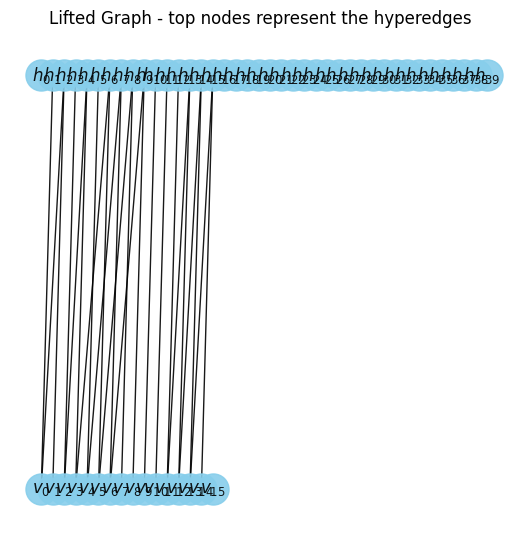

 - Hypergraph with 16 vertices and 40 hyperedges.
 - The nodes have feature dimensions 20.
 - The hyperedges have feature dimensions 20.



In [78]:
lifted_dataset = PreProcessor(dataset, transform_config, loader.data_dir)
describe_data(lifted_dataset)

## Create and Run a Cell NN Model

In this section a simple model is created to test that the used lifting works as intended. In this case the model uses the `incidence_hyperedges` matrix so the lifting should make sure to add it to the data.

In [79]:
from modules.models.hypergraph.unigcn import UniGCNModel

model_type = "hypergraph"
model_id = "unigcn"
model_config = load_model_config(model_type, model_id)

model = UniGCNModel(model_config, dataset_config)


Model configuration for hypergraph UNIGCN:

{'in_channels': None,
 'hidden_channels': 32,
 'out_channels': None,
 'n_layers': 2}


In [80]:
y_hat = model(lifted_dataset.get(0))

If everything is correct the cell above should execute without errors. 